In [2]:
import torch
from torch.nn import functional as F

In [166]:
bsz, C, T = 8, 1, 16
gt = torch.zeros(bsz, C, T) + 1e-12
gt[..., 5:8] = 1
width = 5
padding = (width - 1) // 2

torch.set_printoptions(precision=2, sci_mode=False, )

# 23-width gaussian function
gauss = torch.exp(-torch.arange(width).float()**2 / 2 / 3**2)
conv_weight_gauss = gauss.view(1, 1, -1) / gauss.sum()
gt2 = F.conv1d(gt, conv_weight_gauss, padding=padding)

# rect function
conv_weight = torch.ones(1, 1, width)
gt3 = F.conv1d(gt, conv_weight, padding=padding)
print(gt.shape, gt2.shape, gt3.shape)
print(gt.squeeze(1))
print(gt2.squeeze(1))
print(gt3.squeeze(1))

torch.Size([8, 1, 16]) torch.Size([8, 1, 16]) torch.Size([8, 1, 16])
tensor([[    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,     1.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     1.00,     1.00,   

In [137]:
conv_weight_gauss.shape

torch.Size([1, 1, 23])

In [41]:
gt.sum(), gt2.sum()

(tensor(5.), tensor(5.))

In [42]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('google/flan-t5-base')
model

No sentence-transformers model found with name google/flan-t5-base. Creating a new one with MEAN pooling.


SentenceTransformer(
  (0): Transformer({'max_seq_length': None, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [64]:
tokens = model.tokenize(['asdasd'])
model[0].auto_model.shared(tokens['input_ids'])

tensor([[[ -0.1783,  -4.8474, -11.2574,  ...,   3.0610,   0.8116,  -0.3689],
         [ -8.8058, -11.3521,   5.0098,  ...,  11.4753,   1.5380,   1.2257],
         [ -6.1441,   3.2716,   6.7864,  ...,   6.6642,  -3.1475,  -0.4135],
         [ 15.8271,   7.1912,  15.1406,  ...,   5.4508, -25.9279,  11.4963]]],
       grad_fn=<EmbeddingBackward0>)

In [71]:
list(model[0].auto_model.named_children())
# names of direct children of model[0].auto_model
chilren_names = [name for name, _ in model[0].auto_model.named_children()]
chilren_names

['shared', 'encoder']

In [118]:
model[0].auto_model.encoder

T5Stack(
  (embed_tokens): Embedding(32128, 768)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=768, out_features=768, bias=False)
            (k): Linear(in_features=768, out_features=768, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (o): Linear(in_features=768, out_features=768, bias=False)
            (relative_attention_bias): Embedding(32, 12)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseGatedActDense(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048, bias=False)
            (wo): Linear(in_features=2048, out_features=768, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
      

In [117]:
from transformers.models.t5.modeling_t5 import T5EncoderModel
isinstance(model[0].auto_model, T5EncoderModel.encoder.embed_tokens)

True

In [129]:
tokenizer = model.tokenizer
tokens = tokenizer([
    'What am I doing here?',
    'I am here to help you.',
], return_tensors='pt', padding=True, truncation=True, max_length=128)
model.eval()
m, p = model[0].auto_model, model[1]
# e = m.forward(input_ids=tokens['input_ids'])
e = m.encoder.embed_tokens(tokens['input_ids'])
# emask = m.get_extended_attention_mask(tokens['attention_mask'], e.shape[:2])
z = m.encoder.forward(
    inputs_embeds=e, attention_mask=tokens['attention_mask']).last_hidden_state
# z = m.encoder.final_layer_norm(z)
# z = m.encoder.dropout(z)
z


tensor([[[ 5.4254e-02,  1.1634e-03, -6.1577e-02,  ...,  2.2936e-01,
          -1.5196e-02,  1.8806e-01],
         [ 7.1048e-02,  1.5129e-01, -1.5329e-01,  ...,  1.7882e-01,
           1.3987e-01,  1.1193e-01],
         [-3.3350e-02,  8.4157e-02, -1.3473e-01,  ...,  1.6532e-01,
          -1.0076e-01,  8.4120e-02],
         ...,
         [ 2.6084e-02, -7.3776e-02,  1.4508e-01,  ...,  6.1168e-02,
          -2.2682e-02,  1.1299e-01],
         [ 9.0642e-03,  4.9196e-03,  1.4719e-02,  ...,  1.8979e-03,
          -3.9594e-03,  1.3286e-03],
         [ 4.0707e-03,  7.4475e-05,  8.8705e-03,  ...,  3.4174e-04,
          -1.3661e-02,  6.7632e-03]],

        [[-5.2103e-02,  3.0039e-01, -6.5994e-02,  ..., -9.6555e-04,
           4.9770e-03, -4.3151e-02],
         [ 4.1212e-03,  3.7733e-01, -2.4334e-01,  ...,  2.4809e-02,
           1.4733e-01,  1.2640e-01],
         [-1.1160e-01,  3.5529e-01, -1.7713e-01,  ..., -7.3622e-02,
          -6.7336e-02,  5.8776e-02],
         ...,
         [-8.4614e-02,  1

In [130]:
# model[0].auto_model.forward(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask']).last_hidden_state
model[0].auto_model.encoder.forward(
    inputs_embeds=e, attention_mask=tokens['attention_mask']).last_hidden_state

tensor([[[ 5.4254e-02,  1.1634e-03, -6.1577e-02,  ...,  2.2936e-01,
          -1.5196e-02,  1.8806e-01],
         [ 7.1048e-02,  1.5129e-01, -1.5329e-01,  ...,  1.7882e-01,
           1.3987e-01,  1.1193e-01],
         [-3.3350e-02,  8.4157e-02, -1.3473e-01,  ...,  1.6532e-01,
          -1.0076e-01,  8.4120e-02],
         ...,
         [ 2.6084e-02, -7.3776e-02,  1.4508e-01,  ...,  6.1168e-02,
          -2.2682e-02,  1.1299e-01],
         [ 9.0642e-03,  4.9196e-03,  1.4719e-02,  ...,  1.8979e-03,
          -3.9594e-03,  1.3286e-03],
         [ 4.0707e-03,  7.4475e-05,  8.8705e-03,  ...,  3.4174e-04,
          -1.3661e-02,  6.7632e-03]],

        [[-5.2103e-02,  3.0039e-01, -6.5994e-02,  ..., -9.6555e-04,
           4.9770e-03, -4.3151e-02],
         [ 4.1212e-03,  3.7733e-01, -2.4334e-01,  ...,  2.4809e-02,
           1.4733e-01,  1.2640e-01],
         [-1.1160e-01,  3.5529e-01, -1.7713e-01,  ..., -7.3622e-02,
          -6.7336e-02,  5.8776e-02],
         ...,
         [-8.4614e-02,  1

In [119]:
from sentence_transformers import SentenceTransformer

model_mp = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
model_mp

You try to use a model that was created with version 3.0.0.dev0, however, your version is 2.7.0. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
)

In [136]:
type(model[1]), type(model_mp[1])

(sentence_transformers.models.Pooling.Pooling,
 sentence_transformers.models.Pooling.Pooling)

In [181]:
import json
import numpy as np
from pprint import pformat

print(pformat({'a': 1, 'predictions': np.random.randint(0, 480, size=(5, 2)).astype(float).tolist(), 'logits': np.random.randn(128).tolist()}, compact=True, sort_dicts=False, width=100))

{'a': 1,
 'predictions': [[134.0, 435.0], [271.0, 26.0], [383.0, 339.0], [75.0, 98.0], [452.0, 51.0]],
 'logits': [-1.09812832176763, 2.716887037589855, -0.48141407257914803, -0.09655260901692336,
            0.40671076616875973, 0.5680530038063253, -0.40691983674325005, 0.5075089673108686,
            0.17093913904395755, 0.17711024893501762, 0.3619697714156793, 1.320201149792901,
            0.48453390484050285, 0.19324393897165604, -1.1560222319238804, 0.221640189015644,
            -1.2889102412951865, 0.22679232371560712, -0.6270755925179246, 1.5967837426184681,
            -1.0950327747392243, -0.2801356120174398, 1.2938433297862084, 0.6886693595463713,
            -0.47939411659235676, -0.0034371787779578582, 0.7778526376604185, 1.5985322688359629,
            -0.6534886183057574, 0.8929525251443948, -0.5555555689274062, 1.4800768401455935,
            0.4004717521459343, 0.26373516211345027, -0.041877242391055135, 0.25498580652875413,
            -0.4643773927401182, 0.31714954

In [2]:
import json
from pprint import pprint, pformat
import pandas as pd

data = json.load(open('data/Ego4D-processed/captions/VideoRecap/VideoRecap_1s_train_gathered.json'))

In [3]:
pprint(data['clips'][0], compact=True, width=100)

{'captions': {'end': [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0,
                      15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0,
                      28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0,
                      41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0,
                      54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0,
                      67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0,
                      80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0,
                      93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0,
                      105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0,
                      116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0,
      

In [4]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
data['clips'][0]

{'video_uid': 'cd4cf777-fa95-4226-9453-f00ce43fe323',
 'clip_uid': 'bcfcd2b4-7ca3-45ea-bbeb-0c6bd1ddcaac',
 'video_start_sec': 629.5210286,
 'video_end_sec': 1085.2876952666666,
 'queries': {'start': [113.84899,
   118.80053,
   139.94984,
   165.34552,
   224.31384,
   251.47448,
   293.59669,
   442.89443,
   104.62381,
   161.45,
   193.326,
   242.053],
  'end': [117.34267,
   124.24641,
   202.63045,
   166.82061,
   225.55251,
   291.67211,
   310.33,
   447.66819,
   109.0,
   166.4,
   202.3,
   290.653],
  'query': ['In what location did I see the chandelier',
   'Where was the panda bear before opening the drawer?',
   'How many bottles were on the drawer?',
   'Where did I put the Papers in my hand?',
   'Did I close the box?',
   'Who did I talk to in the living room?',
   'Who did I talk to in the living room?',
   'How many plant pot were on the stairway?',
   'Where was my suitcase?',
   'What did I put on the bed?',
   'Where did I put the books?',
   'Who was I talking

In [6]:
records = []
for clip_idx, clip_data in enumerate(data['clips']):
    if any(key not in clip_data for key in ['captions', 'queries']) or len(clip_data['captions']['text']) < 100 or len(clip_data['queries']['query']) < 1:
        continue
    cap_tokens = list(tokenizer(clip_data['captions']['text'], return_tensors='np', add_special_tokens=False).input_ids)
    query_tokens = list(tokenizer(clip_data['queries']['query'], return_tensors='np', add_special_tokens=False).input_ids)
    record = {
        'clip_uid': clip_data['clip_uid'],
        # 'captions': clip_data['captions'],
        'cap_lens': list(map(len, cap_tokens)),
        'query_lens': list(map(len, query_tokens)),
    }
    records.append(record)
records[0]

{'clip_uid': 'bcfcd2b4-7ca3-45ea-bbeb-0c6bd1ddcaac',
 'cap_lens': [5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  8,
  5,
  5,
  5,
  5,
  7,
  7,
  7,
  7,
  7,
  8,
  7,
  8,
  8,
  8,
  8,
  10,
  8,
  8,
  8,
  8,
  8,
  10,
  8,
  8,
  7,
  5,
  7,
  6,
  10,
  8,
  7,
  8,
  8,
  8,
  9,
  8,
  8,
  8,
  10,
  10,
  8,
  8,
  10,
  6,
  8,
  15,
  11,
  15,
  11,
  11,
  8,
  6,
  8,
  8,
  8,
  8,
  8,
  8,
  11,
  8,
  8,
  8,
  8,
  12,
  8,
  8,
  8,
  8,
  8,
  

In [7]:
df = pd.DataFrame(records)
df

,clip_uid,cap_lens,query_lens
0,bcfcd2b4-7ca3-45ea-bbeb-0c6bd1ddcaac,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[8, 12, 8, 11, 6, 10, 10, 11, 5, 8, 7, 10]"
1,3cd6f6c1-b89f-4241-8b17-dc2dbd09d9e1,"[9, 9, 9, 9, 6, 5, 5, 5, 3, 3, 4, 5, 6, 6, 6, ...","[7, 8, 9, 6, 13, 10, 11, 10, 6, 14, 11, 8, 10,..."
2,fcad17ad-ac2e-4d39-9a0f-da305e027ee7,"[9, 9, 7, 7, 9, 9, 6, 9, 9, 9, 9, 10, 6, 9, 9,...","[6, 12, 9, 16, 6, 17, 12]"
3,7ba2bb39-2c15-42b5-990f-214ef1b730c3,"[9, 15, 13, 12, 7, 9, 12, 8, 9, 11, 12, 12, 13...","[8, 13, 11, 10, 8, 10, 10, 10, 8, 10, 6, 6, 8,..."
4,156f510b-d740-44e8-83a7-96af31eaad5a,"[7, 7, 7, 5, 8, 7, 5, 7, 6, 7, 7, 7, 5, 5, 7, ...","[11, 11, 8, 10, 10, 6, 8, 8]"
...,...,...,...
1253,354f27d5-baaf-4c66-bf5b-ade12eba0ddc,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, ...","[5, 6, 10, 7, 8]"
1254,ba011313-18eb-44d0-92fe-2044b3416d10,"[8, 7, 10, 9, 5, 5, 5, 5, 7, 7, 3, 8, 8, 7, 3,...","[9, 7, 9, 8, 6]"
1255,ed47630e-8c0b-447e-9a14-0b6531e84a18,"[5, 3, 6, 6, 4, 6, 5, 5, 5, 5, 5, 5, 3, 3, 6, ...","[9, 12, 8, 11, 8, 10, 5]"
1256,a45e8d63-57a9-4d7a-a560-b295e78f1fd9,"[6, 10, 7, 9, 8, 12, 4, 5, 11, 9, 8, 13, 14, 1...","[11, 7, 13, 9, 9, 10, 10, 12, 7, 6, 4, 7, 7, 9..."


In [8]:
import numpy as np
print(df['cap_lens'].apply(lambda x: np.mean(x)).describe())
print(df['query_lens'].apply(lambda x: np.mean(x)).describe())

count    1258.000000
mean        7.528416
std         1.914719
min         3.437500
25%         6.159044
50%         7.326403
75%         8.573805
max        14.170478
Name: cap_lens, dtype: float64
count    1258.000000
mean        8.935133
std         1.249768
min         5.000000
25%         8.200000
50%         8.944272
75%         9.666667
max        16.000000
Name: query_lens, dtype: float64


In [9]:
cap_counts = sum(df['cap_lens'].values.tolist(), [])
query_counts = sum(df['query_lens'].values.tolist(), [])

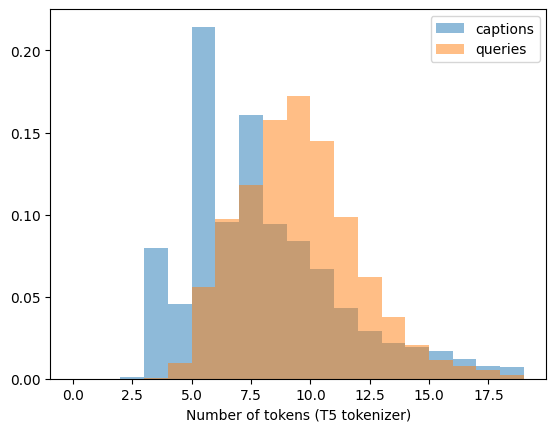

In [10]:
import matplotlib.pyplot as plt
plt.hist(cap_counts, density=True, bins=range(20), alpha=0.5, label='captions')
plt.hist(query_counts, density=True, bins=range(20), alpha=0.5, label='queries')
plt.xlabel('Number of tokens (T5 tokenizer)')
plt.legend()
plt.show()